In [1]:
import numpy as np
import os
import eikonal_funcs_drop as ekf

#constants
c = 3e8#m/s

## Generating a Map

In [2]:
#PARAMETERS

args_station = 11

#icemodel_form = = 'SP5' #Summit Poly5
icemodel_form = 'SE3'    #Summit Exponential3

#should probably change this to a full path instead of a relative one
savedMap_path = f'./timemaps/{icemodel_form}'




#span of eikonal map in meters 
rlimits = [-5,45]
zlimits = [-100,-35]

#resolution of map in meters (motivated by uncertainty of phased array depths via GPS)
stepSize_r = 0.1
stepSize_z = 0.1


#Best fit Parameters for Different Ice Models
ice_pars_SP5 = [917, -93.82894598668852,1420.9803575781268,-9045.59209249893,13747.326534754588,-6674.720814507842]
ice_pars_SE3 = [917.0, 
                -259.8665602846212, -0.045083474912333575, 19.889045647136108, #snow
                -343.3010144218721, -0.020756618521118073, 18.662029514415227, #firn
                -22.30487776484924, -0.03748587343015608, 111.02704353372049   #buble
                ]


#pulser/source location relative to the top of the power string
r_source = 40
z_source = -50

This map took 0 seconds to generate.


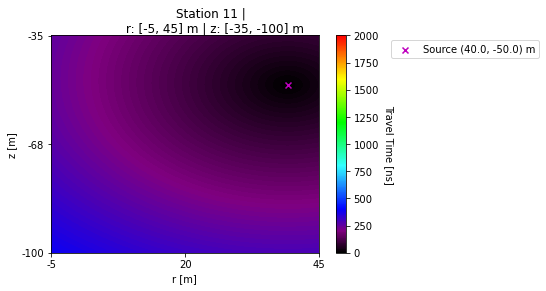

Ch0 Arrvival time: 86.14830264083403 ns


In [3]:
#=====# generate dimensions of map
depths = np.arange(zlimits[1], zlimits[0]-1, -stepSize_z)
distances = np.arange(rlimits[0], rlimits[1]+1, stepSize_r)

#=====# Obtain n(z), accounting for if your depth range extends above the surface
n_ice_depthColumn = ekf.iceModelExp3(depths[depths<=0],ice_pars_SE3)
#n_ice_depthColumn = ekf.iceModelPoly5(depths[depths<=0],ice_pars_SP5)

n_air_depthColumn = np.ones(len(depths[depths>0]))
n_depthColumn = np.concatenate((n_air_depthColumn,n_ice_depthColumn))



#=====# Get v(z), correct required dimensionality, smear v(z) across distance range
v_column = c/n_depthColumn
Vcol_masked = np.array([np.array([y]) for y in v_column])
Vmatrix_mask = np.array([Vcol_masked for x in range(len(distances))])

#=====# Generate the Time Map #=======#
#correct the velocity units, give map indices of source location 
Tmap = ekf.generateTimeMap(Vmatrix_mask/1e9,distances,depths,[ekf.Ind(distances,r_source),ekf.Ind(depths,z_source),0]) 



#Plot Time Map
ekf.plotTmap(Tmap,distances,depths,11)


#get time at different locations

t_ch0 = ekf.getTime(Tmap,distances,depths,[ekf.Ind(distances,0),ekf.Ind(depths,-96)]) #antenna on the power string [r,z] = [0,-96]
print(f'Ch0 Arrvival time: {t_ch0} ns')




<font color='blue'>The maps at this resolution (dr = 0.1m, dz = 0.1m) generate very quickly, but may slow down significantly if you set (dr = 0.01m, dz = 0.01m). 
<br>You may have to choose only a single dimension to have higher resolution to compromise.</font>

## Interpolating Time between Pre-Generated Maps of Different Depths

If you have generated time maps for two different source depths (e.g. -70 and -65) and want to find an arrival time for a pulser at -67

In [9]:
#Generate and Save maps
pulsing_position = [25,-67]
'''
#randomly chosen distance r=25m
Tmap1 = ekf.generateTimeMap(Vmatrix_mask/1e9,distances,depths,[ekf.Ind(distances,pulsing_position[0]),ekf.Ind(depths,-70),0])
ekf.saveTMap(Tmap1,-70,distances,depths,args_station,savedMap_path)

Tmap2 = ekf.generateTimeMap(Vmatrix_mask/1e9,distances,depths,[ekf.Ind(distances,pulsing_position[0]),ekf.Ind(depths,-65),0])
ekf.saveTMap(Tmap2,-65,distances,depths,args_station,savedMap_path)
'''

'\n#randomly chosen distance r=25m\nTmap1 = ekf.generateTimeMap(Vmatrix_mask/1e9,distances,depths,[ekf.Ind(distances,pulsing_position[0]),ekf.Ind(depths,-70),0])\nekf.saveTMap(Tmap1,-70,distances,depths,args_station,savedMap_path)\n\nTmap2 = ekf.generateTimeMap(Vmatrix_mask/1e9,distances,depths,[ekf.Ind(distances,pulsing_position[0]),ekf.Ind(depths,-65),0])\nekf.saveTMap(Tmap2,-65,distances,depths,args_station,savedMap_path)\n'

In [ ]:
#Load two time maps
#os.system('ls -lhtr '+savedMap_path)

mapList = ekf.loadTMaps(args_station, sourceDepth = pulsing_position[-1], sourceDepthStep=5, map_dirpath=savedMap_path)#maps are 5m apart in source depth 
#will load a single map if map exists (e.g. for depth of -65m), or a list of two maps on either side of desired depth (e.g. maps for -70 & -65 for a depth of -67)
print(mapList.shape)

total 0
(2, 660, 510)


In [11]:
# interpolate between 2 different time maps, the interpolation function will be the arrival time at a target point, as a function of the pulser depth
target_position = [0,-96]
interpolated_time = ekf.get_InterpolatedTime(sourceDepth=-67,  sourceDepthStep=5,  time_Maps=mapList,  rdomain=distances,  zdomain=depths,  position=target_position)
print(f'Interpolated time at {target_position} for a pulser at {pulsing_position} is: {interpolated_time} ns')

There is no pre-generated map for -67 m, instead will interpolate between [-70.0, -65.0] m
Interpolated time at [0, -96] for a pulser at [25, -67] is: 219.76122126000456 ns


In [ ]:
#Compare this time with a third map, generated with a source at [25,-67] and find the exact time with ekf.getTime(,,pulsing position)
